In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Path to your GloVe pre-trained embeddings file
glove_file_path = 'glove.6B.300d.txt'

# Load GloVe embeddings
model = load_glove_model(glove_file_path)

Loading Glove Model
400000 words loaded!


In [4]:
word_embedding = model.get('hello')
print((word_embedding))

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [5]:

def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            # Check if word exists in the model's vocabulary
            if word in model:
                embedding.append(model[word])
            else:
                # If word not found, use zero vector
                embedding.append([0] * model["hello"].size)
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83  # maximum length of word in a text
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * model["hello"].size] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    # Filter out None values
    padded_embeddings = [embedding for embedding in padded_embeddings if embedding is not None]

    # Convert to tensor
    input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)

    return input_ids

In [6]:
x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_31891/886969634.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)


In [7]:
x_train.size()

torch.Size([906, 83, 300])

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([906, 83])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = LSTMTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_31891/2600715320.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_31891/2600715320.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_31891/2600715320.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_31891/2600715320.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/150, Train Loss: 1.0052832812070847, Val Loss: 0.60153728723526, Val F1: 0.236489898989899, Train F1: 0.24047012715743246


  1%|█▉                                                                                                                                                | 2/150 [00:03<03:38,  1.47s/it]

Epoch 2/150, Train Loss: 0.5346566252410412, Val Loss: 0.4782519042491913, Val F1: 0.3176088906005162, Train F1: 0.2557423707723196


  2%|██▉                                                                                                                                               | 3/150 [00:04<03:06,  1.27s/it]

Epoch 3/150, Train Loss: 0.4638632908463478, Val Loss: 0.4136981666088104, Val F1: 0.3221328323861033, Train F1: 0.25691261452256337


  3%|███▉                                                                                                                                              | 4/150 [00:05<03:15,  1.34s/it]

Epoch 4/150, Train Loss: 0.4218372143805027, Val Loss: 0.396805077791214, Val F1: 0.3309940412061237, Train F1: 0.2559736810696571


  3%|████▊                                                                                                                                             | 5/150 [00:06<03:10,  1.31s/it]

Epoch 5/150, Train Loss: 0.3999450281262398, Val Loss: 0.3692012131214142, Val F1: 0.33533079561450463, Train F1: 0.2523302892051084


  4%|█████▊                                                                                                                                            | 6/150 [00:08<03:13,  1.35s/it]

Epoch 6/150, Train Loss: 0.36649350449442863, Val Loss: 0.34907999634742737, Val F1: 0.34587708999548106, Train F1: 0.284648634177772


  5%|██████▊                                                                                                                                           | 7/150 [00:09<03:21,  1.41s/it]

Epoch 7/150, Train Loss: 0.36325211077928543, Val Loss: 0.33313220739364624, Val F1: 0.3963922469309205, Train F1: 0.3033275663272455


  5%|███████▊                                                                                                                                          | 8/150 [00:11<03:16,  1.38s/it]

Epoch 8/150, Train Loss: 0.3383396230638027, Val Loss: 0.3171041011810303, Val F1: 0.4278937816393828, Train F1: 0.35789486136119053


  6%|████████▊                                                                                                                                         | 9/150 [00:12<03:06,  1.32s/it]

Epoch 9/150, Train Loss: 0.33028557524085045, Val Loss: 0.3033986985683441, Val F1: 0.45707550950517706, Train F1: 0.36769846176103216


  7%|█████████▋                                                                                                                                       | 10/150 [00:13<03:01,  1.30s/it]

Epoch 10/150, Train Loss: 0.3033995572477579, Val Loss: 0.2904982268810272, Val F1: 0.4647298698449048, Train F1: 0.42524612727788086


  7%|██████████▋                                                                                                                                      | 11/150 [00:15<03:10,  1.37s/it]

Epoch 11/150, Train Loss: 0.29927419126033783, Val Loss: 0.28110814094543457, Val F1: 0.5426232178579183, Train F1: 0.43785378048466733


  8%|███████████▌                                                                                                                                     | 12/150 [00:16<03:12,  1.40s/it]

Epoch 12/150, Train Loss: 0.28003090620040894, Val Loss: 0.2704005241394043, Val F1: 0.53843364222727, Train F1: 0.5056269107676414


  9%|████████████▌                                                                                                                                    | 13/150 [00:17<03:10,  1.39s/it]

Epoch 13/150, Train Loss: 0.27153479866683483, Val Loss: 0.26267513632774353, Val F1: 0.6118186915495155, Train F1: 0.5356919907657247


  9%|█████████████▌                                                                                                                                   | 14/150 [00:19<03:02,  1.34s/it]

Epoch 14/150, Train Loss: 0.26540540531277657, Val Loss: 0.25540122389793396, Val F1: 0.6127674749342401, Train F1: 0.5839926053493946


 10%|██████████████▌                                                                                                                                  | 15/150 [00:20<03:24,  1.51s/it]

Epoch 15/150, Train Loss: 0.2508933339267969, Val Loss: 0.2487512230873108, Val F1: 0.6434664322639746, Train F1: 0.6219813481068945


 11%|███████████████▍                                                                                                                                 | 16/150 [00:22<03:16,  1.47s/it]

Epoch 16/150, Train Loss: 0.2446049489080906, Val Loss: 0.24346160888671875, Val F1: 0.6633512428116917, Train F1: 0.6362283834767173


 11%|████████████████▍                                                                                                                                | 17/150 [00:23<03:08,  1.42s/it]

Epoch 17/150, Train Loss: 0.240127170458436, Val Loss: 0.23987558484077454, Val F1: 0.6874876660244972, Train F1: 0.657566415343459


 12%|█████████████████▍                                                                                                                               | 18/150 [00:24<03:03,  1.39s/it]

Epoch 18/150, Train Loss: 0.24474484100937843, Val Loss: 0.23729029297828674, Val F1: 0.6849371919830362, Train F1: 0.6731565357935706


 13%|██████████████████▎                                                                                                                              | 19/150 [00:26<02:59,  1.37s/it]

Epoch 19/150, Train Loss: 0.24123520031571388, Val Loss: 0.23168660700321198, Val F1: 0.6906453855313058, Train F1: 0.6892081461650716


 13%|███████████████████▎                                                                                                                             | 20/150 [00:27<02:57,  1.37s/it]

Epoch 20/150, Train Loss: 0.24571620859205723, Val Loss: 0.22686293721199036, Val F1: 0.6869779552849068, Train F1: 0.648984238287725


 14%|████████████████████▎                                                                                                                            | 21/150 [00:29<02:55,  1.36s/it]

Epoch 21/150, Train Loss: 0.22443029284477234, Val Loss: 0.23033705353736877, Val F1: 0.6716810420949274, Train F1: 0.698792480787712


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:30<02:44,  1.28s/it]

Epoch 22/150, Train Loss: 0.22923441231250763, Val Loss: 0.22458188235759735, Val F1: 0.6870669341273956, Train F1: 0.7009322706598432


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:31<02:55,  1.38s/it]

Epoch 23/150, Train Loss: 0.208676315844059, Val Loss: 0.22244086861610413, Val F1: 0.7139665178870614, Train F1: 0.7346598620206227


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:33<02:54,  1.39s/it]

Epoch 24/150, Train Loss: 0.20288517884910107, Val Loss: 0.2210768759250641, Val F1: 0.7040355590286135, Train F1: 0.7081598112910115


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:34<02:44,  1.32s/it]

Epoch 25/150, Train Loss: 0.2157713584601879, Val Loss: 0.22252362966537476, Val F1: 0.7239855689854918, Train F1: 0.7143012590401021


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:35<02:45,  1.34s/it]

Epoch 26/150, Train Loss: 0.19680506736040115, Val Loss: 0.2150862067937851, Val F1: 0.7366006945206852, Train F1: 0.743390403021599


 18%|██████████████████████████                                                                                                                       | 27/150 [00:37<02:44,  1.34s/it]

Epoch 27/150, Train Loss: 0.18944794684648514, Val Loss: 0.21733485162258148, Val F1: 0.7034177939196741, Train F1: 0.7592679295253238


 19%|███████████████████████████                                                                                                                      | 28/150 [00:39<03:11,  1.57s/it]

Epoch 28/150, Train Loss: 0.19642063416540623, Val Loss: 0.21340034902095795, Val F1: 0.7201962938133527, Train F1: 0.7261747668876616


 19%|████████████████████████████                                                                                                                     | 29/150 [00:40<03:20,  1.65s/it]

Epoch 29/150, Train Loss: 0.1794572789222002, Val Loss: 0.2125786393880844, Val F1: 0.7025840012228516, Train F1: 0.7644966807752427


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:44<04:24,  2.21s/it]

Epoch 30/150, Train Loss: 0.1723281368613243, Val Loss: 0.21159900724887848, Val F1: 0.7348436954694831, Train F1: 0.7873327654733245


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:48<05:12,  2.63s/it]

Epoch 31/150, Train Loss: 0.17371833138167858, Val Loss: 0.20894993841648102, Val F1: 0.7264004716193911, Train F1: 0.8104046324396149


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:50<05:14,  2.66s/it]

Epoch 32/150, Train Loss: 0.15913596749305725, Val Loss: 0.21268483996391296, Val F1: 0.7160393253266032, Train F1: 0.8177768457533028


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:52<04:40,  2.39s/it]

Epoch 33/150, Train Loss: 0.16349254548549652, Val Loss: 0.20746830105781555, Val F1: 0.7086461820888642, Train F1: 0.8193226462047725


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:54<04:20,  2.24s/it]

Epoch 34/150, Train Loss: 0.16164294630289078, Val Loss: 0.2095784693956375, Val F1: 0.7329258075133689, Train F1: 0.8113743472696051


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:56<03:58,  2.07s/it]

Epoch 35/150, Train Loss: 0.1588735580444336, Val Loss: 0.2047777622938156, Val F1: 0.7383163354854624, Train F1: 0.8245966179116727


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:57<03:41,  1.94s/it]

Epoch 36/150, Train Loss: 0.15194056369364262, Val Loss: 0.20374451577663422, Val F1: 0.7219802498465472, Train F1: 0.8339230544406552


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:59<03:21,  1.79s/it]

Epoch 37/150, Train Loss: 0.14066194836050272, Val Loss: 0.2078627347946167, Val F1: 0.7237251677985622, Train F1: 0.8503381017159073


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [01:00<02:56,  1.57s/it]

Epoch 38/150, Train Loss: 0.14148669503629208, Val Loss: 0.20767995715141296, Val F1: 0.7197946733287731, Train F1: 0.8447822507184574


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [01:01<02:48,  1.52s/it]

Epoch 39/150, Train Loss: 0.1375779788941145, Val Loss: 0.20209045708179474, Val F1: 0.7321006098803804, Train F1: 0.8371376623530353


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [01:03<02:51,  1.56s/it]

Epoch 40/150, Train Loss: 0.13135043531656265, Val Loss: 0.1993294358253479, Val F1: 0.7440829797764975, Train F1: 0.8590294801989475


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [01:04<02:44,  1.51s/it]

Epoch 41/150, Train Loss: 0.134444210678339, Val Loss: 0.20129874348640442, Val F1: 0.7396640763976428, Train F1: 0.8725874553399561


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [01:05<02:35,  1.44s/it]

Epoch 42/150, Train Loss: 0.1264444561675191, Val Loss: 0.2045609951019287, Val F1: 0.7347283438318716, Train F1: 0.8501520626048837


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [01:07<02:23,  1.34s/it]

Epoch 43/150, Train Loss: 0.11790021602064371, Val Loss: 0.2081678807735443, Val F1: 0.7250417863691802, Train F1: 0.8837095945600111


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [01:08<02:21,  1.33s/it]

Epoch 44/150, Train Loss: 0.11860280856490135, Val Loss: 0.21281501650810242, Val F1: 0.7273096307150929, Train F1: 0.8862127412904037


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [01:09<02:15,  1.29s/it]

Epoch 45/150, Train Loss: 0.12145628221333027, Val Loss: 0.2269568145275116, Val F1: 0.7078349490550849, Train F1: 0.8758678447377345


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [01:10<02:04,  1.20s/it]

Epoch 46/150, Train Loss: 0.12264757417142391, Val Loss: 0.20694652199745178, Val F1: 0.7348147739531234, Train F1: 0.8684216593875015


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [01:11<02:00,  1.17s/it]

Epoch 47/150, Train Loss: 0.1109304903075099, Val Loss: 0.2098941057920456, Val F1: 0.7326004826556676, Train F1: 0.8941917008726895


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [01:13<02:06,  1.24s/it]

Epoch 48/150, Train Loss: 0.10670976620167494, Val Loss: 0.20578470826148987, Val F1: 0.7337596519878288, Train F1: 0.8884620529720442


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [01:14<02:17,  1.36s/it]

Epoch 49/150, Train Loss: 0.10322178155183792, Val Loss: 0.2045411318540573, Val F1: 0.7404247312727416, Train F1: 0.9002483984204468


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [01:16<02:25,  1.45s/it]

Epoch 50/150, Train Loss: 0.0934608606621623, Val Loss: 0.21190853416919708, Val F1: 0.7399068221215382, Train F1: 0.9071026706630229


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [01:17<02:03,  1.24s/it]

Epoch 51/150, Train Loss: 0.08735937811434269, Val Loss: 0.21341697871685028, Val F1: 0.7293216702586259, Train F1: 0.9202267340861984


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [01:17<01:48,  1.11s/it]

Epoch 52/150, Train Loss: 0.09179500676691532, Val Loss: 0.21726112067699432, Val F1: 0.7336922867222656, Train F1: 0.9141034109670382


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [01:18<01:41,  1.05s/it]

Epoch 53/150, Train Loss: 0.08580045774579048, Val Loss: 0.21307513117790222, Val F1: 0.7272484146900161, Train F1: 0.9202378283921689


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [01:19<01:28,  1.08it/s]

Epoch 54/150, Train Loss: 0.08456444554030895, Val Loss: 0.2183908075094223, Val F1: 0.7312636237483044, Train F1: 0.9218777789813334


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [01:20<01:20,  1.18it/s]

Epoch 55/150, Train Loss: 0.09296128712594509, Val Loss: 0.21067166328430176, Val F1: 0.7421292371740092, Train F1: 0.9114769221830313


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [01:20<01:13,  1.27it/s]

Epoch 56/150, Train Loss: 0.0904006864875555, Val Loss: 0.22004002332687378, Val F1: 0.739576454058268, Train F1: 0.9123861883139132


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [01:21<01:09,  1.34it/s]

Epoch 57/150, Train Loss: 0.08376236911863089, Val Loss: 0.21419428288936615, Val F1: 0.7312798657146248, Train F1: 0.9321702135343729


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [01:22<01:06,  1.39it/s]

Epoch 58/150, Train Loss: 0.07158806174993515, Val Loss: 0.21757425367832184, Val F1: 0.7359090986381052, Train F1: 0.9404579744598516


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [01:22<01:05,  1.39it/s]

Epoch 59/150, Train Loss: 0.07016599411144853, Val Loss: 0.21842306852340698, Val F1: 0.7411631629266328, Train F1: 0.9432734120264625


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [01:23<01:03,  1.43it/s]

Epoch 60/150, Train Loss: 0.06604423141106963, Val Loss: 0.22466698288917542, Val F1: 0.7276743202093874, Train F1: 0.9489838079634729


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [01:24<01:05,  1.35it/s]

Epoch 61/150, Train Loss: 0.07279052259400487, Val Loss: 0.22904621064662933, Val F1: 0.7389312096103074, Train F1: 0.9426469384901561


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [01:24<01:02,  1.40it/s]

Epoch 62/150, Train Loss: 0.06921176100149751, Val Loss: 0.22430987656116486, Val F1: 0.7275441604256822, Train F1: 0.9404384316492481


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [01:25<01:00,  1.43it/s]

Epoch 63/150, Train Loss: 0.06592733645811677, Val Loss: 0.23197594285011292, Val F1: 0.7288659498402694, Train F1: 0.9435630369973816


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [01:26<01:02,  1.37it/s]

Epoch 64/150, Train Loss: 0.06187433749437332, Val Loss: 0.2389942854642868, Val F1: 0.725411481172315, Train F1: 0.9456902032126908


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [01:27<01:00,  1.41it/s]

Epoch 65/150, Train Loss: 0.058381487149745226, Val Loss: 0.24539585411548615, Val F1: 0.715008627293218, Train F1: 0.9532675774439022


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [01:27<00:59,  1.41it/s]

Epoch 66/150, Train Loss: 0.056100019020959735, Val Loss: 0.2469128668308258, Val F1: 0.720228657843017, Train F1: 0.9569407181746002


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [01:28<00:57,  1.44it/s]

Epoch 67/150, Train Loss: 0.05696937954053283, Val Loss: 0.25333917140960693, Val F1: 0.7154602462391754, Train F1: 0.9532347899256775


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [01:29<00:55,  1.47it/s]

Epoch 68/150, Train Loss: 0.05603957828134298, Val Loss: 0.24875418841838837, Val F1: 0.7321168072266353, Train F1: 0.9592925781862498


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [01:30<01:01,  1.31it/s]

Epoch 69/150, Train Loss: 0.055027632508426905, Val Loss: 0.24266165494918823, Val F1: 0.7338603059121507, Train F1: 0.9571655025159163


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [01:30<00:58,  1.36it/s]

Epoch 70/150, Train Loss: 0.049626785796135664, Val Loss: 0.25448304414749146, Val F1: 0.7181698435855339, Train F1: 0.964770803214401


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [01:31<00:56,  1.40it/s]

Epoch 71/150, Train Loss: 0.04809209052473307, Val Loss: 0.2384142428636551, Val F1: 0.7233960017817193, Train F1: 0.9661788582823307


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [01:32<00:55,  1.39it/s]

Epoch 72/150, Train Loss: 0.04859994072467089, Val Loss: 0.2524491548538208, Val F1: 0.7317192611033564, Train F1: 0.9654813593667614


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [01:32<00:55,  1.38it/s]

Epoch 73/150, Train Loss: 0.04331442597322166, Val Loss: 0.24899432063102722, Val F1: 0.7241497162454937, Train F1: 0.9692664720811975


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [01:33<00:53,  1.41it/s]

Epoch 74/150, Train Loss: 0.04388073552399874, Val Loss: 0.250104159116745, Val F1: 0.7250249294212443, Train F1: 0.9671103408602499


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [01:34<00:53,  1.41it/s]

Epoch 75/150, Train Loss: 0.045057345647364855, Val Loss: 0.2587301731109619, Val F1: 0.7316588406737724, Train F1: 0.9666148768868936


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [01:34<00:52,  1.41it/s]

Epoch 76/150, Train Loss: 0.043260324047878385, Val Loss: 0.25874608755111694, Val F1: 0.7285734063531547, Train F1: 0.9695922405316894


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [01:35<00:50,  1.43it/s]

Epoch 77/150, Train Loss: 0.04220253089442849, Val Loss: 0.2655375003814697, Val F1: 0.7197638186185396, Train F1: 0.968391952907877


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [01:36<00:53,  1.35it/s]

Epoch 78/150, Train Loss: 0.04471584805287421, Val Loss: 0.26931729912757874, Val F1: 0.7246841926741098, Train F1: 0.9684494729420243


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [01:37<00:53,  1.33it/s]

Epoch 79/150, Train Loss: 0.039547045016661286, Val Loss: 0.26894620060920715, Val F1: 0.720032599901436, Train F1: 0.972036455923341


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [01:37<00:50,  1.40it/s]

Epoch 80/150, Train Loss: 0.03738009091466665, Val Loss: 0.2753266990184784, Val F1: 0.7230140809729133, Train F1: 0.9615051800602199


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [01:38<00:48,  1.43it/s]

Epoch 81/150, Train Loss: 0.04321699682623148, Val Loss: 0.2722277045249939, Val F1: 0.7290599300667804, Train F1: 0.971426780652365


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [01:39<00:46,  1.45it/s]

Epoch 82/150, Train Loss: 0.03726869565434754, Val Loss: 0.2776278257369995, Val F1: 0.7254752282129543, Train F1: 0.9731810571674232


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [01:39<00:45,  1.46it/s]

Epoch 83/150, Train Loss: 0.03886416205205023, Val Loss: 0.2795458734035492, Val F1: 0.724588660843371, Train F1: 0.9722979811013965


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [01:40<00:44,  1.49it/s]

Epoch 84/150, Train Loss: 0.03906394960358739, Val Loss: 0.29117414355278015, Val F1: 0.7079893528636275, Train F1: 0.9741406287757086


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [01:41<00:43,  1.48it/s]

Epoch 85/150, Train Loss: 0.041432535042986274, Val Loss: 0.26407578587532043, Val F1: 0.7307676277984921, Train F1: 0.9724169651459345


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [01:41<00:43,  1.47it/s]

Epoch 86/150, Train Loss: 0.0459006205201149, Val Loss: 0.26992732286453247, Val F1: 0.7226866853993417, Train F1: 0.9662936521198262


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [01:42<00:43,  1.46it/s]

Epoch 87/150, Train Loss: 0.042508252896368504, Val Loss: 0.2660665810108185, Val F1: 0.7283441748065362, Train F1: 0.9625816725920839


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [01:43<00:42,  1.47it/s]

Epoch 88/150, Train Loss: 0.043640024960041046, Val Loss: 0.25367555022239685, Val F1: 0.7376906354062324, Train F1: 0.9657946658663009


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [01:43<00:41,  1.45it/s]

Epoch 89/150, Train Loss: 0.041159435641020536, Val Loss: 0.26493749022483826, Val F1: 0.72891965503488, Train F1: 0.9689762448459126


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [01:44<00:41,  1.45it/s]

Epoch 90/150, Train Loss: 0.04148259572684765, Val Loss: 0.2603866159915924, Val F1: 0.7316940049046267, Train F1: 0.9625346727239505


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [01:45<00:40,  1.45it/s]

Epoch 91/150, Train Loss: 0.04317890130914748, Val Loss: 0.26388004422187805, Val F1: 0.7249554803561571, Train F1: 0.9648359387880999


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [01:46<00:39,  1.48it/s]

Epoch 92/150, Train Loss: 0.03529447049368173, Val Loss: 0.25737378001213074, Val F1: 0.7364845628245216, Train F1: 0.9748469845542915


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [01:46<00:38,  1.47it/s]

Epoch 93/150, Train Loss: 0.03736076899804175, Val Loss: 0.25862476229667664, Val F1: 0.7360003873778602, Train F1: 0.9751433538504756


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [01:47<00:38,  1.44it/s]

Epoch 94/150, Train Loss: 0.032429907005280256, Val Loss: 0.29097384214401245, Val F1: 0.7226870601074081, Train F1: 0.9750916372440921


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [01:48<00:38,  1.44it/s]

Epoch 95/150, Train Loss: 0.04136638552881777, Val Loss: 0.27232852578163147, Val F1: 0.7223978113289277, Train F1: 0.9720559306849854


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [01:48<00:37,  1.45it/s]

Epoch 96/150, Train Loss: 0.03294696309603751, Val Loss: 0.2808690071105957, Val F1: 0.7266021074748874, Train F1: 0.9718696783385071


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [01:49<00:35,  1.48it/s]

Epoch 97/150, Train Loss: 0.03287218674086034, Val Loss: 0.278890997171402, Val F1: 0.7215323817511217, Train F1: 0.9755339156743976


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [01:50<00:35,  1.46it/s]

Epoch 98/150, Train Loss: 0.0335406584199518, Val Loss: 0.28600963950157166, Val F1: 0.7232504620671385, Train F1: 0.9738373572445596


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [01:50<00:35,  1.45it/s]

Epoch 99/150, Train Loss: 0.03237521508708596, Val Loss: 0.27978751063346863, Val F1: 0.724973489349694, Train F1: 0.9777770627159341


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [01:51<00:34,  1.47it/s]

Epoch 100/150, Train Loss: 0.03176171355880797, Val Loss: 0.29873400926589966, Val F1: 0.7199007492500223, Train F1: 0.9715702031007627


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [01:52<00:33,  1.48it/s]

Epoch 101/150, Train Loss: 0.02980307349935174, Val Loss: 0.28501278162002563, Val F1: 0.724064105980814, Train F1: 0.9762866899598468


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [01:52<00:32,  1.48it/s]

Epoch 102/150, Train Loss: 0.033218407770618796, Val Loss: 0.28798720240592957, Val F1: 0.7219872958155734, Train F1: 0.9706410119804308


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [01:53<00:32,  1.46it/s]

Epoch 103/150, Train Loss: 0.030353498179465532, Val Loss: 0.2940998077392578, Val F1: 0.71958085917966, Train F1: 0.977954918805056


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [01:54<00:31,  1.45it/s]

Epoch 104/150, Train Loss: 0.028439596062526107, Val Loss: 0.29340457916259766, Val F1: 0.7176309852242984, Train F1: 0.9786835922447503


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [01:54<00:30,  1.46it/s]

Epoch 105/150, Train Loss: 0.026840732607524842, Val Loss: 0.3031617999076843, Val F1: 0.7166171500817077, Train F1: 0.9797704615578866


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [01:55<00:30,  1.46it/s]

Epoch 106/150, Train Loss: 0.03037228505127132, Val Loss: 0.29632318019866943, Val F1: 0.715593552921474, Train F1: 0.9782789321541981


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [01:56<00:29,  1.47it/s]

Epoch 107/150, Train Loss: 0.026949483202770352, Val Loss: 0.3043329417705536, Val F1: 0.719755430430924, Train F1: 0.9779924623621516


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [01:56<00:28,  1.50it/s]

Epoch 108/150, Train Loss: 0.028244033455848694, Val Loss: 0.30259162187576294, Val F1: 0.7185056297052119, Train F1: 0.9740333477754486


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [01:57<00:27,  1.51it/s]

Epoch 109/150, Train Loss: 0.02797910524532199, Val Loss: 0.30148085951805115, Val F1: 0.720701969472553, Train F1: 0.9757376863932637


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [01:58<00:26,  1.52it/s]

Epoch 110/150, Train Loss: 0.02993337856605649, Val Loss: 0.3126891553401947, Val F1: 0.7219881330998562, Train F1: 0.9760764165931832


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [01:58<00:25,  1.53it/s]

Epoch 111/150, Train Loss: 0.025973970186896622, Val Loss: 0.308240681886673, Val F1: 0.7223672230468724, Train F1: 0.980399974186076


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [01:59<00:24,  1.54it/s]

Epoch 112/150, Train Loss: 0.028358837822452188, Val Loss: 0.3106617331504822, Val F1: 0.7218101426220063, Train F1: 0.9783415421292627


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [02:00<00:24,  1.54it/s]

Epoch 113/150, Train Loss: 0.02604208351112902, Val Loss: 0.3049251437187195, Val F1: 0.7219123249770173, Train F1: 0.9805676490438155


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [02:00<00:23,  1.54it/s]

Epoch 114/150, Train Loss: 0.026061611250042915, Val Loss: 0.309928834438324, Val F1: 0.7182353989052732, Train F1: 0.9802314750545504


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [02:01<00:22,  1.55it/s]

Epoch 115/150, Train Loss: 0.02938199695199728, Val Loss: 0.3209279179573059, Val F1: 0.7161423425209149, Train F1: 0.9759430967065282


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [02:02<00:21,  1.55it/s]

Epoch 116/150, Train Loss: 0.025289022596552968, Val Loss: 0.31321993470191956, Val F1: 0.7155603636414254, Train F1: 0.9806021814116962


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [02:02<00:21,  1.55it/s]

Epoch 117/150, Train Loss: 0.02503953769337386, Val Loss: 0.32134050130844116, Val F1: 0.7168453315428084, Train F1: 0.980851263907052


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [02:03<00:20,  1.55it/s]

Epoch 118/150, Train Loss: 0.024369640334043652, Val Loss: 0.3212910592556, Val F1: 0.7132154798982082, Train F1: 0.9811972685343154


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [02:04<00:20,  1.55it/s]

Epoch 119/150, Train Loss: 0.026587646454572678, Val Loss: 0.3221166133880615, Val F1: 0.7176309852242984, Train F1: 0.9776098030807766


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [02:04<00:19,  1.55it/s]

Epoch 120/150, Train Loss: 0.025313371093943715, Val Loss: 0.3213858902454376, Val F1: 0.7194956089464188, Train F1: 0.9810403908675247


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [02:05<00:19,  1.50it/s]

Epoch 121/150, Train Loss: 0.02642110758461058, Val Loss: 0.3202282786369324, Val F1: 0.7211832964006767, Train F1: 0.9793191668552879


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [02:06<00:18,  1.48it/s]

Epoch 122/150, Train Loss: 0.028272896306589246, Val Loss: 0.3293400704860687, Val F1: 0.7197384727431207, Train F1: 0.9786102122126459


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [02:06<00:18,  1.48it/s]

Epoch 123/150, Train Loss: 0.02535027777776122, Val Loss: 0.3288891911506653, Val F1: 0.7206454243630009, Train F1: 0.9792852944159309


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [02:07<00:17,  1.48it/s]

Epoch 124/150, Train Loss: 0.027299605077132583, Val Loss: 0.32381153106689453, Val F1: 0.7224147419979121, Train F1: 0.9753889954192447


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [02:08<00:17,  1.43it/s]

Epoch 125/150, Train Loss: 0.028593525057658553, Val Loss: 0.32543808221817017, Val F1: 0.7197996756752915, Train F1: 0.977656432007603


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [02:08<00:16,  1.44it/s]

Epoch 126/150, Train Loss: 0.026126955170184374, Val Loss: 0.33444228768348694, Val F1: 0.7197784461198852, Train F1: 0.9732423377054055


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [02:09<00:15,  1.46it/s]

Epoch 127/150, Train Loss: 0.023767228645738214, Val Loss: 0.33087730407714844, Val F1: 0.7227018953637322, Train F1: 0.9814064184548468


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [02:10<00:15,  1.43it/s]

Epoch 128/150, Train Loss: 0.025506787933409214, Val Loss: 0.3320111930370331, Val F1: 0.7259756846540605, Train F1: 0.9802548921822734


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [02:10<00:14,  1.46it/s]

Epoch 129/150, Train Loss: 0.023369548318441957, Val Loss: 0.33444151282310486, Val F1: 0.7191369814162442, Train F1: 0.9813191747346396


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [02:11<00:13,  1.49it/s]

Epoch 130/150, Train Loss: 0.025686658453196287, Val Loss: 0.3336401879787445, Val F1: 0.7236979371778144, Train F1: 0.9792448375035099


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [02:12<00:12,  1.50it/s]

Epoch 131/150, Train Loss: 0.026961716590449214, Val Loss: 0.3366906940937042, Val F1: 0.7210535456620922, Train F1: 0.9795669792339649


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [02:12<00:11,  1.51it/s]

Epoch 132/150, Train Loss: 0.027305010706186295, Val Loss: 0.33790531754493713, Val F1: 0.7146305551597533, Train F1: 0.9754719031896044


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [02:13<00:11,  1.51it/s]

Epoch 133/150, Train Loss: 0.026997441658750176, Val Loss: 0.340696781873703, Val F1: 0.7181361414143166, Train F1: 0.9770694363823841


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [02:14<00:10,  1.49it/s]

Epoch 134/150, Train Loss: 0.025047940434888005, Val Loss: 0.3335903286933899, Val F1: 0.7234901127047021, Train F1: 0.9791611487249037


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [02:14<00:09,  1.50it/s]

Epoch 135/150, Train Loss: 0.02513846755027771, Val Loss: 0.34584859013557434, Val F1: 0.713820918830781, Train F1: 0.9782547767362011


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [02:15<00:09,  1.49it/s]

Epoch 136/150, Train Loss: 0.02310503472108394, Val Loss: 0.3364426791667938, Val F1: 0.721118014765155, Train F1: 0.9805918589450543


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [02:16<00:08,  1.46it/s]

Epoch 137/150, Train Loss: 0.02814160706475377, Val Loss: 0.35037603974342346, Val F1: 0.7140512640917884, Train F1: 0.9746872852802194


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [02:17<00:08,  1.41it/s]

Epoch 138/150, Train Loss: 0.024686275282874703, Val Loss: 0.34793621301651, Val F1: 0.7085341153309086, Train F1: 0.9805943483608041


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [02:17<00:07,  1.40it/s]

Epoch 139/150, Train Loss: 0.029459355399012566, Val Loss: 0.35209545493125916, Val F1: 0.7162445559728531, Train F1: 0.979121541657934


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [02:18<00:07,  1.41it/s]

Epoch 140/150, Train Loss: 0.025608796859160066, Val Loss: 0.3414178788661957, Val F1: 0.7196866657163619, Train F1: 0.9804240583521084


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [02:19<00:06,  1.42it/s]

Epoch 141/150, Train Loss: 0.0230016298010014, Val Loss: 0.3488604724407196, Val F1: 0.7188135182884224, Train F1: 0.9815919770514433


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [02:19<00:05,  1.44it/s]

Epoch 142/150, Train Loss: 0.02395504480227828, Val Loss: 0.3475436568260193, Val F1: 0.7174213820948676, Train F1: 0.9802996913376573


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [02:20<00:04,  1.46it/s]

Epoch 143/150, Train Loss: 0.022851839486975223, Val Loss: 0.34760186076164246, Val F1: 0.7208710066083494, Train F1: 0.9816604674426842


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [02:21<00:04,  1.48it/s]

Epoch 144/150, Train Loss: 0.027634072583168745, Val Loss: 0.3571447432041168, Val F1: 0.7191863405933873, Train F1: 0.9767436670203752


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [02:21<00:03,  1.48it/s]

Epoch 145/150, Train Loss: 0.02326014020945877, Val Loss: 0.3518179655075073, Val F1: 0.7187578563317847, Train F1: 0.9806092521052001


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [02:22<00:02,  1.50it/s]

Epoch 146/150, Train Loss: 0.02465087384916842, Val Loss: 0.3489830791950226, Val F1: 0.7123363798263403, Train F1: 0.9797260171264279


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [02:23<00:01,  1.51it/s]

Epoch 147/150, Train Loss: 0.022744515212252736, Val Loss: 0.34985190629959106, Val F1: 0.7119902600678593, Train F1: 0.9819806264472992


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [02:23<00:01,  1.52it/s]

Epoch 148/150, Train Loss: 0.02566561254207045, Val Loss: 0.35739344358444214, Val F1: 0.706757375089099, Train F1: 0.9789206734821347


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [02:24<00:00,  1.53it/s]

Epoch 149/150, Train Loss: 0.02722094114869833, Val Loss: 0.3539954423904419, Val F1: 0.7165701110561947, Train F1: 0.971918566247834


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:25<00:00,  1.03it/s]

Epoch 150/150, Train Loss: 0.024122860515490174, Val Loss: 0.34359094500541687, Val F1: 0.720813425420005, Train F1: 0.9792884988695226


In [12]:
# Save the model
torch.save(model.state_dict(), 't2_model2_glove.pth')

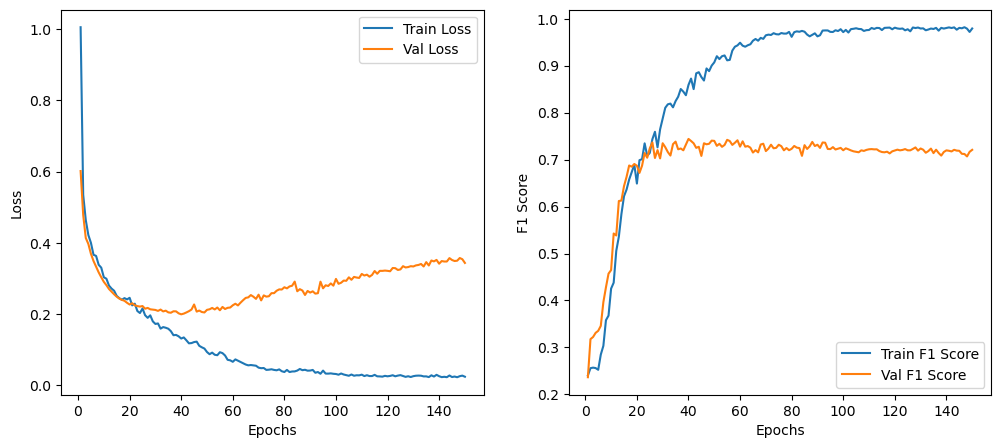

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()